# EDA

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from ast import literal_eval
from sklearn.model_selection import train_test_split
from ndlinear import NdLinear  # Make sure this is in your environment
import re


# Path to dataset
DATA_PATH = "data"
all_records = []

## Loop through each country folder to combine dataset

In [2]:
import os
import pandas as pd
import re

DATA_PATH = "data"
all_records = []

# Loop through each country folder inside the dataset directory
for country in os.listdir(DATA_PATH):
    country_path = os.path.join(DATA_PATH, country)
    img_path = os.path.join(country_path)

    # Proceed only if the path is a directory (i.e., a country folder)
    if os.path.isdir(country_path):
        # Collect all label files with .txt extension
        txt_files = [f for f in os.listdir(country_path) if f.endswith(".txt")]
        print(f"{country}: Found {len(txt_files)} labels")

        # Parse each label file
        for txt_file in txt_files:
            txt_path = os.path.join(country_path, txt_file)
            with open(txt_path, "r") as f:
                line = f.readline().strip()
                parts = line.split("\t")

                # Ensure the label file has all required components
                if len(parts) >= 6:
                    file_name, x, y, w, h, plate_number = parts[:6]
                    file_path = os.path.join(img_path, file_name)

                    # Create a record with bounding box and metadata
                    record = {
                        "file_name": file_name,
                        "file_path": file_path,
                        "x": int(x),
                        "y": int(y),
                        "w": int(w),
                        "h": int(h),
                        "bbox": [int(x), int(y), int(x) + int(w), int(y) + int(h)],
                        "license_plate.number": plate_number,
                        "country": country,
                    }
                    all_records.append(record)

# Create a combined DataFrame from all collected records
df_all = pd.DataFrame(all_records)

# Define a helper function to check if a license plate is valid (alphanumeric only)
def is_valid_plate(plate):
    return isinstance(plate, str) and bool(re.match(r'^[A-Za-z0-9]+$', plate))

# Clean the DataFrame:
# 1. Drop rows with missing critical fields
# 2. Filter out records with invalid license plate formats
df_all = df_all.dropna(subset=["license_plate.number", "bbox", "file_path"])
df_all = df_all[df_all["license_plate.number"].apply(is_valid_plate)].reset_index(drop=True)

.ipynb_checkpoints: Found 0 labels
eu: Found 108 labels
br: Found 114 labels
us: Found 222 labels


  Country  Num Images
0      us         222
1      br         114
2      eu         108


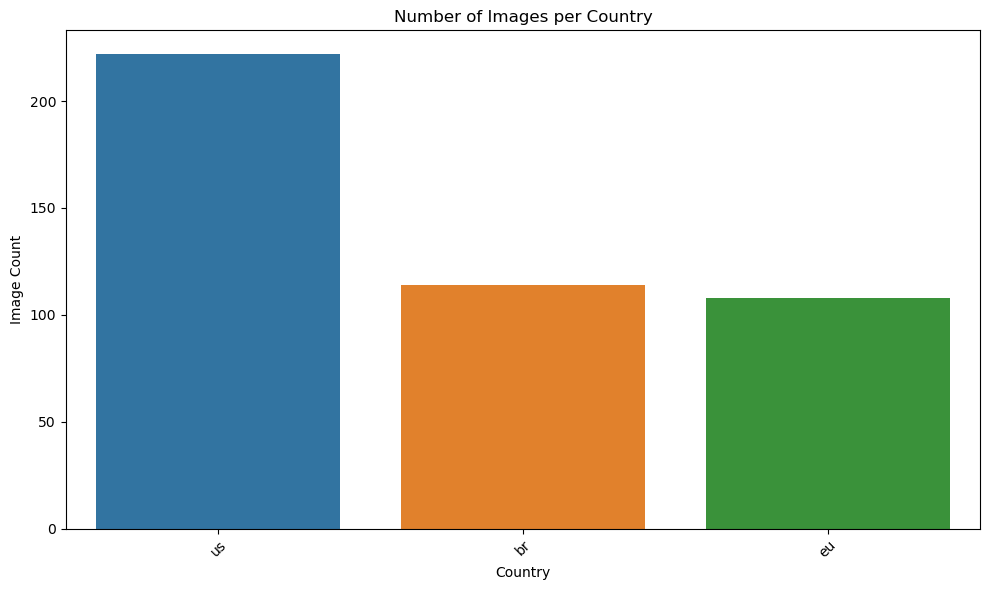

In [3]:
# --- EDA: Count by Country ---
# Count the number of images available per country
country_counts = df_all["country"].value_counts().reset_index()
country_counts.columns = ["Country", "Num Images"]

# Display the count table
print(country_counts)

# --- Plot: Distribution of Images by Country ---
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
sns.barplot(data=country_counts, x="Country", y="Num Images")  # Create bar plot
plt.title("Number of Images per Country")  # Set plot title
plt.ylabel("Image Count")  # Set y-axis label
plt.xlabel("Country")  # Set x-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

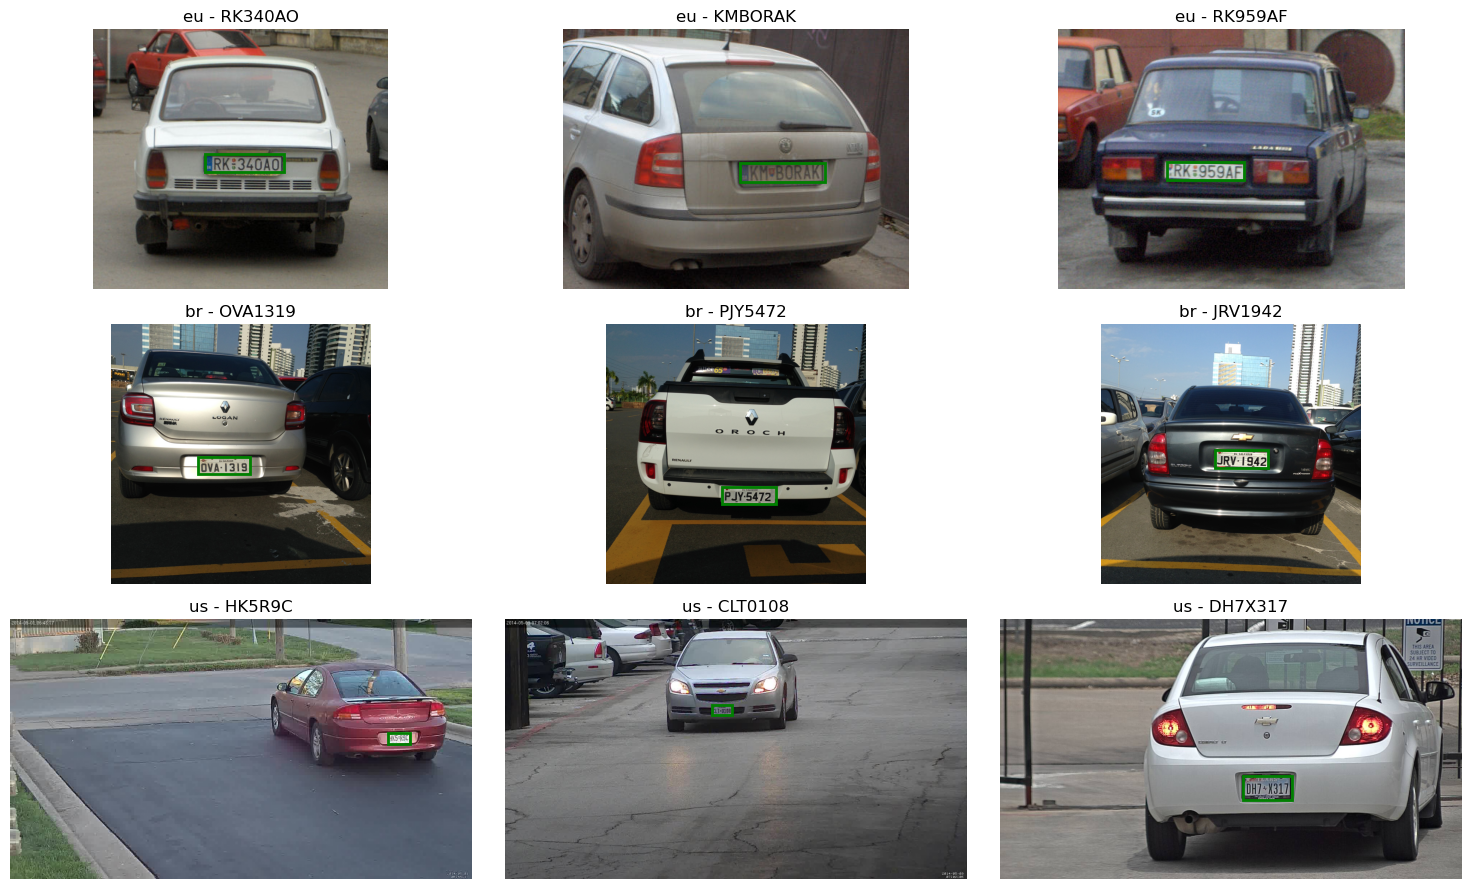

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# --- Plot Sample Images per Country ---
def plot_country_samples(df, num_per_country=3):
    """
    Displays a grid of sample images per country with license plate bounding boxes.

    Parameters:
    - df (pd.DataFrame): DataFrame containing license plate image paths and metadata
    - num_per_country (int): Number of sample images to display per country
    """
    countries = df["country"].unique()
    fig, axs = plt.subplots(len(countries), num_per_country, figsize=(15, 3 * len(countries)))

    for i, country in enumerate(countries):
        # Sample images for the current country
        sample_df = df[df["country"] == country].sample(num_per_country)

        for j, (_, row) in enumerate(sample_df.iterrows()):
            image = Image.open(row["file_path"])
            bbox = row["bbox"]  # bounding box in [x1, y1, x2, y2] format

            # Handle single-row case for axs (flattened array)
            ax = axs[i, j] if len(countries) > 1 else axs[j]

            # Display the image
            ax.imshow(image)

            # Draw bounding box
            ax.add_patch(plt.Rectangle(
                (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                edgecolor='green', facecolor='none', linewidth=2
            ))

            # Set title and remove axes
            ax.set_title(f"{country} - {row['license_plate.number']}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# --- Call the function to display sample images ---
plot_country_samples(df_all)

In [5]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
from ast import literal_eval

# ---- Dataset Class for License Plate Detection ----
class LicensePlateDataset(Dataset):
    def __init__(self, dataframe, transform=None, normalize_bbox=False):
        """
        Custom PyTorch Dataset for loading license plate images and bounding boxes.

        Parameters:
        - dataframe (pd.DataFrame): DataFrame containing file paths and bounding boxes.
        - transform (callable, optional): Transformations to apply to the image. Defaults to resizing to 224x224 and converting to tensor.
        - normalize_bbox (bool): If True, normalizes bounding box coordinates to the transformed image size.
        """
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.normalize_bbox = normalize_bbox

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding bounding box at the specified index.

        Returns:
        - image (Tensor): Transformed image tensor.
        - bbox (Tensor): Bounding box tensor [x1, y1, x2, y2]. Normalized if specified.
        """
        row = self.df.iloc[idx]

        # Load and convert image to RGB
        image = Image.open(row["file_path"]).convert("RGB")

        # Safely evaluate the bbox string if necessary
        bbox = row["bbox"]
        if isinstance(bbox, str):
            bbox = literal_eval(bbox)

        bbox = torch.tensor(bbox, dtype=torch.float32)

        # Store original image dimensions before resizing
        orig_w, orig_h = image.size

        # Apply image transformation (resize and tensor conversion)
        image = self.transform(image)

        # Normalize bounding box coordinates to match resized image dimensions (224x224)
        if self.normalize_bbox:
            bbox[0] = bbox[0] / orig_w * 224
            bbox[1] = bbox[1] / orig_h * 224
            bbox[2] = bbox[2] / orig_w * 224
            bbox[3] = bbox[3] / orig_h * 224

        return image, bbox

# Bounding Box detection - Linear

Epoch 1/50: 100%|██████████| 23/23 [00:03<00:00,  6.15it/s]


Epoch 1 - Train Loss: 0.0552 | Val Loss: 0.0503 | Train IoU: 0.0000 | Val IoU: 0.0000 | Val mAP50: 0.0000


Epoch 2/50: 100%|██████████| 23/23 [00:02<00:00,  7.77it/s]


Epoch 2 - Train Loss: 0.0307 | Val Loss: 0.0242 | Train IoU: 0.1010 | Val IoU: 0.1012 | Val mAP50: 0.0337


Epoch 3/50: 100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


Epoch 3 - Train Loss: 0.0375 | Val Loss: 0.0275 | Train IoU: 0.1201 | Val IoU: 0.1363 | Val mAP50: 0.0225


Epoch 4/50: 100%|██████████| 23/23 [00:02<00:00,  7.78it/s]


Epoch 4 - Train Loss: 0.0439 | Val Loss: 0.0327 | Train IoU: 0.0896 | Val IoU: 0.1075 | Val mAP50: 0.0112


Epoch 5/50: 100%|██████████| 23/23 [00:03<00:00,  7.58it/s]


Epoch 5 - Train Loss: 0.0314 | Val Loss: 0.0241 | Train IoU: 0.1610 | Val IoU: 0.1522 | Val mAP50: 0.0787


Epoch 6/50: 100%|██████████| 23/23 [00:03<00:00,  7.56it/s]


Epoch 6 - Train Loss: 0.0313 | Val Loss: 0.0266 | Train IoU: 0.2014 | Val IoU: 0.2001 | Val mAP50: 0.0449


Epoch 7/50: 100%|██████████| 23/23 [00:03<00:00,  7.60it/s]


Epoch 7 - Train Loss: 0.0219 | Val Loss: 0.0115 | Train IoU: 0.2431 | Val IoU: 0.2387 | Val mAP50: 0.0562


Epoch 8/50: 100%|██████████| 23/23 [00:03<00:00,  7.46it/s]


Epoch 8 - Train Loss: 0.0180 | Val Loss: 0.0107 | Train IoU: 0.2254 | Val IoU: 0.2367 | Val mAP50: 0.1124


Epoch 9/50: 100%|██████████| 23/23 [00:02<00:00,  7.88it/s]


Epoch 9 - Train Loss: 0.0187 | Val Loss: 0.0108 | Train IoU: 0.2676 | Val IoU: 0.2776 | Val mAP50: 0.2584


Epoch 10/50: 100%|██████████| 23/23 [00:03<00:00,  7.47it/s]


Epoch 10 - Train Loss: 0.0341 | Val Loss: 0.0272 | Train IoU: 0.2837 | Val IoU: 0.2778 | Val mAP50: 0.1910


Epoch 11/50: 100%|██████████| 23/23 [00:02<00:00,  7.91it/s]


Epoch 11 - Train Loss: 0.0169 | Val Loss: 0.0117 | Train IoU: 0.3483 | Val IoU: 0.3701 | Val mAP50: 0.4157


Epoch 12/50: 100%|██████████| 23/23 [00:03<00:00,  7.63it/s]


Epoch 12 - Train Loss: 0.0144 | Val Loss: 0.0072 | Train IoU: 0.3361 | Val IoU: 0.3312 | Val mAP50: 0.2697


Epoch 13/50: 100%|██████████| 23/23 [00:02<00:00,  7.81it/s]


Epoch 13 - Train Loss: 0.0152 | Val Loss: 0.0080 | Train IoU: 0.3283 | Val IoU: 0.3305 | Val mAP50: 0.2360


Epoch 14/50: 100%|██████████| 23/23 [00:02<00:00,  7.93it/s]


Epoch 14 - Train Loss: 0.0062 | Val Loss: 0.0047 | Train IoU: 0.4097 | Val IoU: 0.3987 | Val mAP50: 0.3596


Epoch 15/50: 100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


Epoch 15 - Train Loss: 0.0060 | Val Loss: 0.0022 | Train IoU: 0.4121 | Val IoU: 0.3994 | Val mAP50: 0.3371


Epoch 16/50: 100%|██████████| 23/23 [00:03<00:00,  7.52it/s]


Epoch 16 - Train Loss: 0.0337 | Val Loss: 0.0243 | Train IoU: 0.3660 | Val IoU: 0.3570 | Val mAP50: 0.3820


Epoch 17/50: 100%|██████████| 23/23 [00:02<00:00,  7.71it/s]


Epoch 17 - Train Loss: 0.0117 | Val Loss: 0.0065 | Train IoU: 0.3889 | Val IoU: 0.3694 | Val mAP50: 0.4157


Epoch 18/50: 100%|██████████| 23/23 [00:02<00:00,  7.77it/s]


Epoch 18 - Train Loss: 0.0137 | Val Loss: 0.0068 | Train IoU: 0.4004 | Val IoU: 0.4047 | Val mAP50: 0.4270


Epoch 19/50: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]


Epoch 19 - Train Loss: 0.0088 | Val Loss: 0.0055 | Train IoU: 0.3496 | Val IoU: 0.3422 | Val mAP50: 0.3146


Epoch 20/50: 100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


Epoch 20 - Train Loss: 0.0029 | Val Loss: 0.0014 | Train IoU: 0.4082 | Val IoU: 0.4076 | Val mAP50: 0.3708


Epoch 21/50: 100%|██████████| 23/23 [00:02<00:00,  7.70it/s]


Epoch 21 - Train Loss: 0.0094 | Val Loss: 0.0045 | Train IoU: 0.4379 | Val IoU: 0.4200 | Val mAP50: 0.4157


Epoch 22/50: 100%|██████████| 23/23 [00:03<00:00,  7.63it/s]


Epoch 22 - Train Loss: 0.0050 | Val Loss: 0.0065 | Train IoU: 0.4335 | Val IoU: 0.4230 | Val mAP50: 0.4607


Epoch 23/50: 100%|██████████| 23/23 [00:03<00:00,  7.50it/s]


Epoch 23 - Train Loss: 0.0283 | Val Loss: 0.0228 | Train IoU: 0.3414 | Val IoU: 0.3395 | Val mAP50: 0.3483


Epoch 24/50: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s]


Epoch 24 - Train Loss: 0.0093 | Val Loss: 0.0089 | Train IoU: 0.4428 | Val IoU: 0.4197 | Val mAP50: 0.4607


Epoch 25/50: 100%|██████████| 23/23 [00:02<00:00,  7.98it/s]


Epoch 25 - Train Loss: 0.0165 | Val Loss: 0.0274 | Train IoU: 0.3565 | Val IoU: 0.3115 | Val mAP50: 0.3596


Epoch 26/50: 100%|██████████| 23/23 [00:02<00:00,  7.71it/s]


Epoch 26 - Train Loss: 0.0014 | Val Loss: 0.0012 | Train IoU: 0.4556 | Val IoU: 0.4357 | Val mAP50: 0.4494


Epoch 27/50: 100%|██████████| 23/23 [00:02<00:00,  7.81it/s]


Epoch 27 - Train Loss: 0.0024 | Val Loss: 0.0013 | Train IoU: 0.3906 | Val IoU: 0.3696 | Val mAP50: 0.3146


Epoch 28/50: 100%|██████████| 23/23 [00:03<00:00,  7.39it/s]


Epoch 28 - Train Loss: 0.0015 | Val Loss: 0.0011 | Train IoU: 0.4583 | Val IoU: 0.4565 | Val mAP50: 0.5056


Epoch 29/50: 100%|██████████| 23/23 [00:02<00:00,  7.79it/s]


Epoch 29 - Train Loss: 0.0047 | Val Loss: 0.0063 | Train IoU: 0.4827 | Val IoU: 0.4725 | Val mAP50: 0.5618


Epoch 30/50: 100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


Epoch 30 - Train Loss: 0.0073 | Val Loss: 0.0044 | Train IoU: 0.5137 | Val IoU: 0.5147 | Val mAP50: 0.6180


Epoch 31/50: 100%|██████████| 23/23 [00:02<00:00,  7.91it/s]


Epoch 31 - Train Loss: 0.0125 | Val Loss: 0.0069 | Train IoU: 0.4753 | Val IoU: 0.4843 | Val mAP50: 0.5730


Epoch 32/50: 100%|██████████| 23/23 [00:02<00:00,  7.84it/s]


Epoch 32 - Train Loss: 0.0009 | Val Loss: 0.0009 | Train IoU: 0.4787 | Val IoU: 0.4576 | Val mAP50: 0.4607


Epoch 33/50: 100%|██████████| 23/23 [00:03<00:00,  7.64it/s]


Epoch 33 - Train Loss: 0.0077 | Val Loss: 0.0081 | Train IoU: 0.4262 | Val IoU: 0.4174 | Val mAP50: 0.4831


Epoch 34/50: 100%|██████████| 23/23 [00:02<00:00,  7.80it/s]


Epoch 34 - Train Loss: 0.0075 | Val Loss: 0.0059 | Train IoU: 0.4240 | Val IoU: 0.3975 | Val mAP50: 0.3596


Epoch 35/50: 100%|██████████| 23/23 [00:02<00:00,  7.71it/s]


Epoch 35 - Train Loss: 0.0077 | Val Loss: 0.0061 | Train IoU: 0.4435 | Val IoU: 0.4380 | Val mAP50: 0.5393
Early stopping.


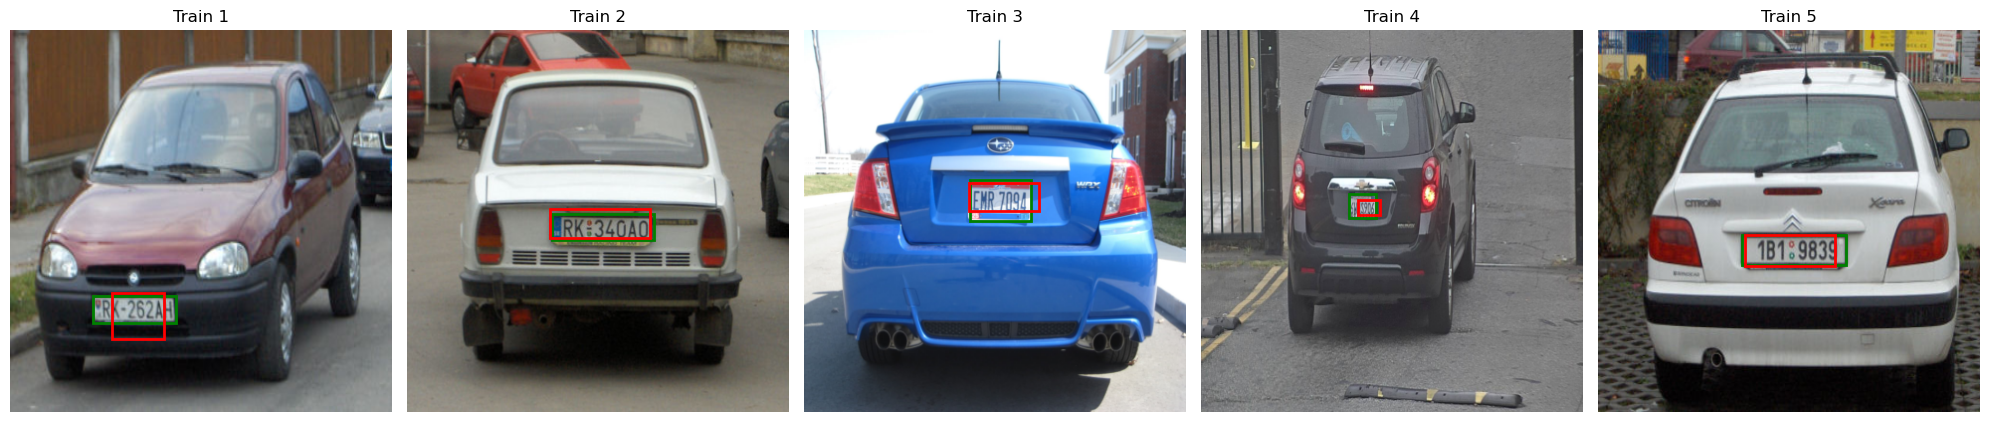

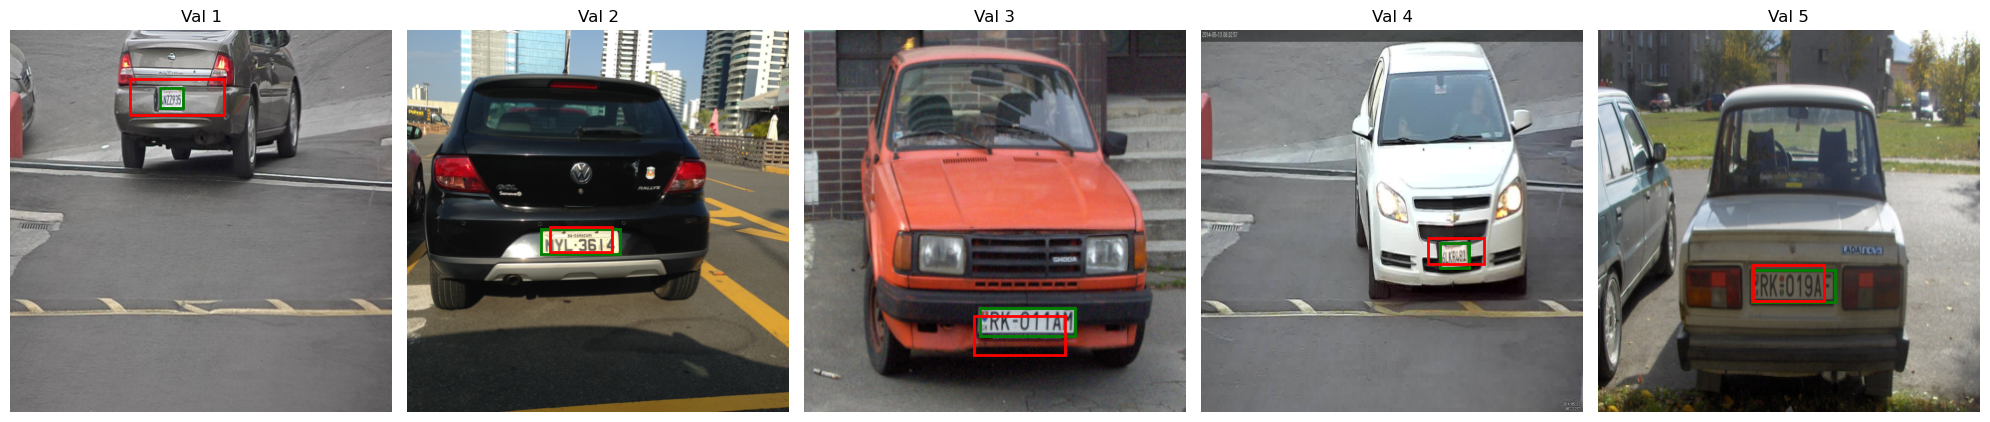

In [7]:
# === Required Libraries ===
import os, torch, torchvision, numpy as np
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# --------------------------------------
# 1. Custom Dataset for License Plate Detection
# --------------------------------------
class LicensePlateDataset(Dataset):
    """
    PyTorch Dataset class for loading license plate images and bounding boxes.
    Normalizes bounding box coordinates to [0, 1] range for model training.
    """
    def __init__(self, df, image_size=(384, 384), augment=False):
        """
        Args:
            df (pd.DataFrame): DataFrame containing 'file_path' and 'bbox'
            image_size (tuple): Target size for image resizing
            augment (bool): Whether to apply data augmentation (currently unused)
        """
        self.df = df
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        Returns:
            image (Tensor): Resized and normalized image tensor
            bbox (Tensor): Normalized bounding box tensor [x1, y1, x2, y2]
        """
        row = self.df.iloc[idx]
        image = Image.open(row['file_path']).convert("RGB")
        orig_w, orig_h = image.size
        image = self.transform(image)

        # Normalize bbox coordinates
        x1, y1, x2, y2 = row['bbox']
        bbox = torch.tensor([
            x1 / orig_w,
            y1 / orig_h,
            x2 / orig_w,
            y2 / orig_h
        ], dtype=torch.float32)

        return image, bbox


# --------------------------------------
# 2. ResNet101-based Bounding Box Regressor
# --------------------------------------
class ResNet101BBoxRegressor(nn.Module):
    """
    Bounding box regression model built on top of a pretrained ResNet101.
    Fine-tunes later layers and adds a custom regression head for 4-point bounding box output.
    """
    def __init__(self):
        super().__init__()

        # Load pretrained ResNet101 as backbone
        resnet = models.resnet101(pretrained=True)

        # Fine-tune only the last two ResNet layers
        for name, param in resnet.named_parameters():
            param.requires_grad = any(layer in name for layer in ["layer3", "layer4"])

        # Remove classification head
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # Pool features to fixed spatial size
        self.pool = nn.AdaptiveAvgPool2d((4, 4))  # Output shape: (2048, 4, 4)

        # Custom head: fully connected layers for bounding box regression
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048 * 4 * 4, 8192),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Sigmoid()  # Ensure bounding box output in [0, 1]
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        return self.regressor(x)


# --------------------------------------
# 3. CIoU Loss Function
# --------------------------------------
def ciou_loss(preds, targets, eps=1e-6):
    """
    Computes the Complete IoU (CIoU) loss between predicted and target bounding boxes.

    Args:
        preds (Tensor): Predicted bounding boxes [B, 4]
        targets (Tensor): Ground truth bounding boxes [B, 4]

    Returns:
        Tensor: Mean CIoU loss across the batch
    """
    # Extract box coordinates
    px1, py1, px2, py2 = preds[:, 0], preds[:, 1], preds[:, 2], preds[:, 3]
    tx1, ty1, tx2, ty2 = targets[:, 0], targets[:, 1], targets[:, 2], targets[:, 3]

    # Intersection
    inter_x1 = torch.max(px1, tx1)
    inter_y1 = torch.max(py1, ty1)
    inter_x2 = torch.min(px2, tx2)
    inter_y2 = torch.min(py2, ty2)
    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)

    # Areas and union
    pred_area = (px2 - px1).clamp(0) * (py2 - py1).clamp(0)
    target_area = (tx2 - tx1).clamp(0) * (ty2 - ty1).clamp(0)
    union_area = pred_area + target_area - inter_area + eps
    iou = inter_area / union_area

    # Center distance
    cx_pred = (px1 + px2) / 2
    cy_pred = (py1 + py2) / 2
    cx_true = (tx1 + tx2) / 2
    cy_true = (ty1 + ty2) / 2
    center_dist = (cx_pred - cx_true) ** 2 + (cy_pred - cy_true) ** 2

    # Smallest enclosing box diagonal
    enclosing_x1 = torch.min(px1, tx1)
    enclosing_y1 = torch.min(py1, ty1)
    enclosing_x2 = torch.max(px2, tx2)
    enclosing_y2 = torch.max(py2, ty2)
    enclosing_diag = (enclosing_x2 - enclosing_x1) ** 2 + (enclosing_y2 - enclosing_y1) ** 2 + eps

    # CIoU score
    ciou = iou - center_dist / enclosing_diag
    return 1 - ciou.mean()


# --------------------------------------
# 4. Model Training with Early Stopping and Logging
# --------------------------------------
def train(model, train_loader, val_loader, device, epochs=50, patience=5, alpha=0.5):
    """
    Train a bounding box regression model using combined SmoothL1 + CIoU loss.

    Args:
        model (nn.Module): The model to train
        train_loader (DataLoader): DataLoader for training data
        val_loader (DataLoader): DataLoader for validation data
        device (torch.device): Training device (CPU/GPU)
        epochs (int): Number of training epochs
        patience (int): Early stopping patience
        alpha (float): Weight for combining losses (0 = pure CIoU, 1 = pure SmoothL1)
    """
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    reg_loss_fn = nn.SmoothL1Loss()

    best_iou = 0
    patience_counter = 0
    metrics_log = []

    def compute_iou(box1, box2):
        """
        Helper to compute IoU between two bounding boxes.
        """
        xA, yA = max(box1[0], box2[0]), max(box1[1], box2[1])
        xB, yB = min(box1[2], box2[2]), min(box1[3], box2[3])
        inter = max(0, xB - xA) * max(0, yB - yA)
        area1 = max(0, box1[2] - box1[0]) * max(0, box1[3] - box1[1])
        area2 = max(0, box2[2] - box2[0]) * max(0, box2[3] - box2[1])
        return inter / (area1 + area2 - inter + 1e-6)

    def evaluate(model, dataloader):
        """
        Evaluates the model on a given dataloader.

        Returns:
            avg_iou (float): Average IoU
            map_50 (float): Proportion of predictions with IoU > 0.5
            avg_loss (float): Average regression loss
        """
        model.eval()
        ious, total_loss = [], 0

        with torch.no_grad():
            for images, targets in dataloader:
                images, targets = images.to(device), targets.to(device)
                preds = model(images)
                total_loss += reg_loss_fn(preds, targets).item()
                preds, targets = preds.cpu().numpy(), targets.cpu().numpy()

                for p, t in zip(preds, targets):
                    ious.append(compute_iou(p, t))

        avg_loss = total_loss / len(dataloader)
        return np.mean(ious), np.mean([1 if i > 0.5 else 0 for i in ious]), avg_loss

    # --- Training Loop ---
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, targets = images.to(device), targets.to(device)
            preds = model(images)

            # Combine SmoothL1 and CIoU losses
            loss = alpha * reg_loss_fn(preds, targets) + (1 - alpha) * ciou_loss(preds, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate model on train and validation sets
        train_iou, train_map, train_loss = evaluate(model, train_loader)
        val_iou, val_map, val_loss = evaluate(model, val_loader)

        # Log epoch metrics
        metrics_log.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_iou': train_iou,
            'val_iou': val_iou,
            'val_map50': val_map
        })

        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train IoU: {train_iou:.4f} | Val IoU: {val_iou:.4f} | Val mAP50: {val_map:.4f}")

        # Checkpointing and early stopping
        if val_iou > best_iou:
            best_iou = val_iou
            patience_counter = 0
            torch.save(model.state_dict(), "best_resnet101_smoothl1_ciou.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break

    # Save training metrics to CSV
    pd.DataFrame(metrics_log).to_csv("training_metrics_bbox_log.csv", index=False)


# --------------------------------------
# 5. Prediction Visualization
# --------------------------------------
def show_predictions(model, dataset, device, label="Sample", num_samples=5):
    """
    Visualizes ground truth and predicted bounding boxes on random samples.

    Args:
        model (nn.Module): Trained model
        dataset (Dataset): Dataset to sample from
        device (torch.device): Computation device
        label (str): Label prefix for subplot titles
        num_samples (int): Number of samples to show
    """
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i in range(num_samples):
        image, true_bbox = dataset[i]
        with torch.no_grad():
            pred_bbox = model(image.unsqueeze(0).to(device)).squeeze().cpu()

        # Convert image and bounding boxes to display format
        image_np = image.permute(1, 2, 0).numpy()
        h, w = image_np.shape[:2]
        true_bbox = true_bbox.numpy() * np.array([w, h, w, h])
        pred_bbox = pred_bbox.numpy() * np.array([w, h, w, h])

        ax = axes[i]
        ax.imshow(image_np)
        ax.add_patch(patches.Rectangle((true_bbox[0], true_bbox[1]), true_bbox[2]-true_bbox[0], true_bbox[3]-true_bbox[1], edgecolor='green', linewidth=2, fill=False))
        ax.add_patch(patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2]-pred_bbox[0], pred_bbox[3]-pred_bbox[1], edgecolor='red', linewidth=2, fill=False))
        ax.set_title(f"{label} {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# --------------------------------------
# 6. Train and Visualize
# --------------------------------------
# Split dataset into training and validation sets
df_train, df_val = train_test_split(df_all, test_size=0.2, random_state=42)

# Create dataset and dataloader instances
train_dataset = LicensePlateDataset(df_train, image_size=(384, 384))
val_dataset = LicensePlateDataset(df_val, image_size=(384, 384))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Initialize model and start training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet101BBoxRegressor()
train(model, train_loader, val_loader, device)

# Visualize predictions on train and validation sets
show_predictions(model, train_dataset, device, label="Train")
show_predictions(model, val_dataset, device, label="Val")

# Bounding Box detection - NDLinear

Epoch 1/50: 100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


Epoch 1 - Train Loss: 0.0666 | Val Loss: 0.0556 | Train IoU: 0.0743 | Val IoU: 0.0756 | Val mAP50: 0.0000


Epoch 2/50: 100%|██████████| 23/23 [00:03<00:00,  7.64it/s]


Epoch 2 - Train Loss: 0.0555 | Val Loss: 0.0452 | Train IoU: 0.0428 | Val IoU: 0.0561 | Val mAP50: 0.0000


Epoch 3/50: 100%|██████████| 23/23 [00:03<00:00,  7.54it/s]


Epoch 3 - Train Loss: 0.0307 | Val Loss: 0.0219 | Train IoU: 0.0949 | Val IoU: 0.1256 | Val mAP50: 0.0225


Epoch 4/50: 100%|██████████| 23/23 [00:02<00:00,  7.71it/s]


Epoch 4 - Train Loss: 0.0208 | Val Loss: 0.0141 | Train IoU: 0.1108 | Val IoU: 0.1554 | Val mAP50: 0.0787


Epoch 5/50: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]


Epoch 5 - Train Loss: 0.0224 | Val Loss: 0.0133 | Train IoU: 0.1345 | Val IoU: 0.1606 | Val mAP50: 0.0449


Epoch 6/50: 100%|██████████| 23/23 [00:03<00:00,  7.29it/s]


Epoch 6 - Train Loss: 0.0155 | Val Loss: 0.0101 | Train IoU: 0.2627 | Val IoU: 0.2682 | Val mAP50: 0.1910


Epoch 7/50: 100%|██████████| 23/23 [00:03<00:00,  7.60it/s]


Epoch 7 - Train Loss: 0.0164 | Val Loss: 0.0105 | Train IoU: 0.3138 | Val IoU: 0.3459 | Val mAP50: 0.3596


Epoch 8/50: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s]


Epoch 8 - Train Loss: 0.0123 | Val Loss: 0.0083 | Train IoU: 0.3476 | Val IoU: 0.3578 | Val mAP50: 0.3933


Epoch 9/50: 100%|██████████| 23/23 [00:03<00:00,  7.51it/s]


Epoch 9 - Train Loss: 0.0223 | Val Loss: 0.0162 | Train IoU: 0.2720 | Val IoU: 0.2771 | Val mAP50: 0.2022


Epoch 10/50: 100%|██████████| 23/23 [00:03<00:00,  7.44it/s]


Epoch 10 - Train Loss: 0.0130 | Val Loss: 0.0088 | Train IoU: 0.2526 | Val IoU: 0.2488 | Val mAP50: 0.1011


Epoch 11/50: 100%|██████████| 23/23 [00:03<00:00,  7.49it/s]


Epoch 11 - Train Loss: 0.0229 | Val Loss: 0.0140 | Train IoU: 0.3261 | Val IoU: 0.3621 | Val mAP50: 0.3596


Epoch 12/50: 100%|██████████| 23/23 [00:03<00:00,  7.26it/s]


Epoch 12 - Train Loss: 0.0194 | Val Loss: 0.0125 | Train IoU: 0.2180 | Val IoU: 0.1906 | Val mAP50: 0.0337


Epoch 13/50: 100%|██████████| 23/23 [00:02<00:00,  7.70it/s]


Epoch 13 - Train Loss: 0.0105 | Val Loss: 0.0046 | Train IoU: 0.3793 | Val IoU: 0.3586 | Val mAP50: 0.3034


Epoch 14/50: 100%|██████████| 23/23 [00:03<00:00,  7.61it/s]


Epoch 14 - Train Loss: 0.0067 | Val Loss: 0.0040 | Train IoU: 0.3114 | Val IoU: 0.3131 | Val mAP50: 0.2135


Epoch 15/50: 100%|██████████| 23/23 [00:03<00:00,  7.53it/s]


Epoch 15 - Train Loss: 0.0089 | Val Loss: 0.0076 | Train IoU: 0.3901 | Val IoU: 0.3655 | Val mAP50: 0.3258


Epoch 16/50: 100%|██████████| 23/23 [00:02<00:00,  7.71it/s]


Epoch 16 - Train Loss: 0.0104 | Val Loss: 0.0048 | Train IoU: 0.4156 | Val IoU: 0.4195 | Val mAP50: 0.4045


Epoch 17/50: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]


Epoch 17 - Train Loss: 0.0047 | Val Loss: 0.0043 | Train IoU: 0.4020 | Val IoU: 0.4219 | Val mAP50: 0.4607


Epoch 18/50: 100%|██████████| 23/23 [00:03<00:00,  7.50it/s]


Epoch 18 - Train Loss: 0.0168 | Val Loss: 0.0108 | Train IoU: 0.4579 | Val IoU: 0.4481 | Val mAP50: 0.4719


Epoch 19/50: 100%|██████████| 23/23 [00:03<00:00,  7.66it/s]


Epoch 19 - Train Loss: 0.0136 | Val Loss: 0.0077 | Train IoU: 0.4321 | Val IoU: 0.4297 | Val mAP50: 0.4944


Epoch 20/50: 100%|██████████| 23/23 [00:03<00:00,  7.58it/s]


Epoch 20 - Train Loss: 0.0051 | Val Loss: 0.0010 | Train IoU: 0.4512 | Val IoU: 0.4523 | Val mAP50: 0.5730


Epoch 21/50: 100%|██████████| 23/23 [00:03<00:00,  7.66it/s]


Epoch 21 - Train Loss: 0.0141 | Val Loss: 0.0076 | Train IoU: 0.4408 | Val IoU: 0.4614 | Val mAP50: 0.4944


Epoch 22/50: 100%|██████████| 23/23 [00:03<00:00,  7.59it/s]


Epoch 22 - Train Loss: 0.0143 | Val Loss: 0.0075 | Train IoU: 0.4558 | Val IoU: 0.4533 | Val mAP50: 0.4944


Epoch 23/50: 100%|██████████| 23/23 [00:03<00:00,  6.93it/s]


Epoch 23 - Train Loss: 0.0109 | Val Loss: 0.0055 | Train IoU: 0.4522 | Val IoU: 0.4587 | Val mAP50: 0.5056


Epoch 24/50: 100%|██████████| 23/23 [00:03<00:00,  7.19it/s]


Epoch 24 - Train Loss: 0.0052 | Val Loss: 0.0019 | Train IoU: 0.4465 | Val IoU: 0.4647 | Val mAP50: 0.4719


Epoch 25/50: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s]


Epoch 25 - Train Loss: 0.0074 | Val Loss: 0.0035 | Train IoU: 0.4685 | Val IoU: 0.4827 | Val mAP50: 0.6180


Epoch 26/50: 100%|██████████| 23/23 [00:03<00:00,  7.64it/s]


Epoch 26 - Train Loss: 0.0081 | Val Loss: 0.0044 | Train IoU: 0.4712 | Val IoU: 0.4513 | Val mAP50: 0.4719


Epoch 27/50: 100%|██████████| 23/23 [00:03<00:00,  7.61it/s]


Epoch 27 - Train Loss: 0.0109 | Val Loss: 0.0065 | Train IoU: 0.4655 | Val IoU: 0.4605 | Val mAP50: 0.5393


Epoch 28/50: 100%|██████████| 23/23 [00:02<00:00,  7.69it/s]


Epoch 28 - Train Loss: 0.0077 | Val Loss: 0.0052 | Train IoU: 0.4723 | Val IoU: 0.4534 | Val mAP50: 0.4831


Epoch 29/50: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]


Epoch 29 - Train Loss: 0.0072 | Val Loss: 0.0048 | Train IoU: 0.4698 | Val IoU: 0.4606 | Val mAP50: 0.5281


Epoch 30/50: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]


Epoch 30 - Train Loss: 0.0140 | Val Loss: 0.0137 | Train IoU: 0.4149 | Val IoU: 0.3981 | Val mAP50: 0.4382
Early stopping.


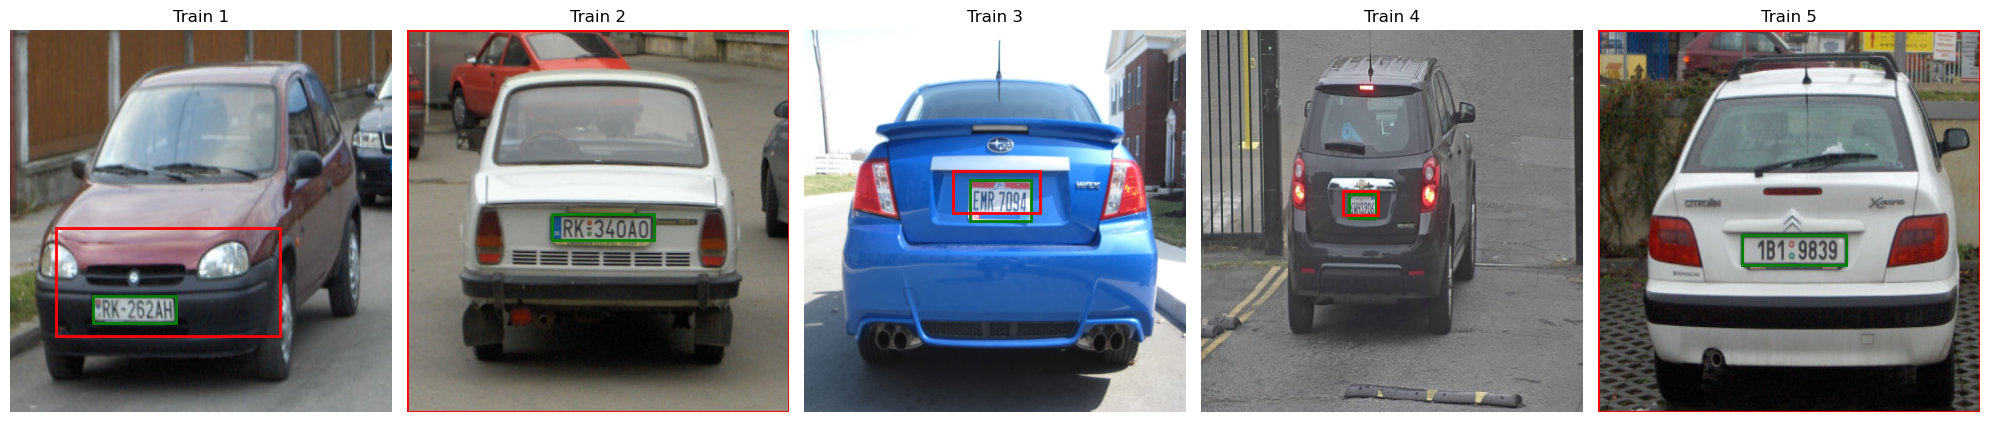

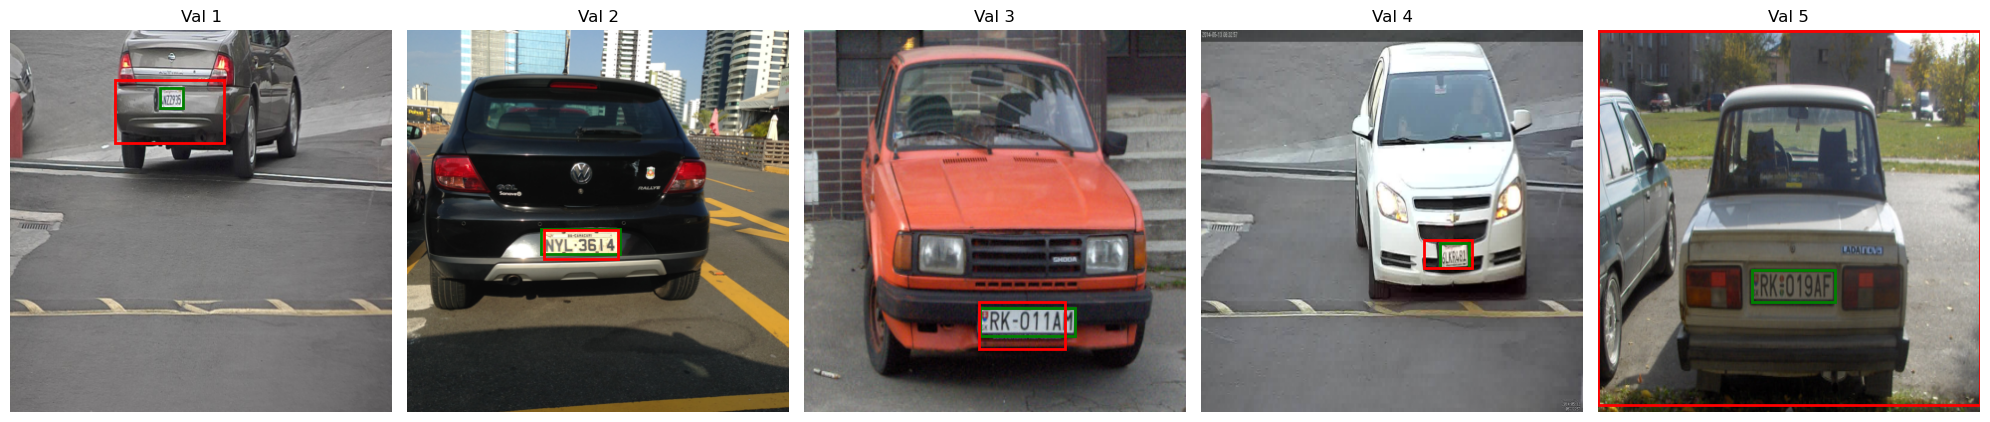

In [9]:
# === Required Libraries ===
import os, torch, torchvision, numpy as np
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ndlinear import NdLinear

# -------------------------
# 1. Custom Dataset for License Plate Detection
# -------------------------
class LicensePlateDataset(Dataset):
    """
    A custom PyTorch Dataset to load license plate images and their bounding boxes.
    BBox coordinates are normalized to [0,1] relative to image dimensions.
    """
    def __init__(self, df, image_size=(384, 384)):
        """
        Args:
            df (pd.DataFrame): DataFrame containing 'file_path' and 'bbox' columns
            image_size (tuple): Target size to resize each image
        """
        self.df = df
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        Returns:
            image (Tensor): Transformed image tensor
            bbox (Tensor): Normalized bounding box [x1, y1, x2, y2]
        """
        row = self.df.iloc[idx]
        image = Image.open(row['file_path']).convert("RGB")
        orig_w, orig_h = image.size
        image = self.transform(image)

        x1, y1, x2, y2 = row['bbox']
        bbox = torch.tensor([
            x1 / orig_w,
            y1 / orig_h,
            x2 / orig_w,
            y2 / orig_h
        ], dtype=torch.float32)

        return image, bbox

# -------------------------
# 2. ResNet101 with NdLinear BBox Regressor
# -------------------------
class ResNet101NdBBoxRegressor(nn.Module):
    """
    Bounding box regression model using a ResNet101 backbone with a fully connected head.
    Only the last ResNet layers are fine-tuned. Outputs 4 normalized coordinates.
    """
    def __init__(self):
        super().__init__()

        # Load pretrained ResNet101 model
        resnet = models.resnet101(pretrained=True)

        # Fine-tune only the last blocks
        for name, param in resnet.named_parameters():
            param.requires_grad = any(layer in name for layer in ["layer3", "layer4"])

        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Remove classification head
        self.pool = nn.AdaptiveAvgPool2d((4, 4))  # Output shape: (2048, 4, 4)

        # Regression head: Linear layers for bounding box prediction
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048 * 4 * 4, 8192),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Sigmoid()  # Output in [0, 1] for normalized coordinates
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        return self.regressor(x)

# -------------------------
# 3. CIoU Loss Function
# -------------------------
def ciou_loss(preds, targets, eps=1e-6):
    """
    Computes the Complete IoU (CIoU) loss between predicted and target bounding boxes.

    Args:
        preds (Tensor): Predicted bounding boxes (B, 4)
        targets (Tensor): Ground-truth bounding boxes (B, 4)

    Returns:
        Tensor: Mean CIoU loss across the batch
    """
    # Coordinates
    px1, py1, px2, py2 = preds[:, 0], preds[:, 1], preds[:, 2], preds[:, 3]
    tx1, ty1, tx2, ty2 = targets[:, 0], targets[:, 1], targets[:, 2], targets[:, 3]

    # Intersection
    inter_x1 = torch.max(px1, tx1)
    inter_y1 = torch.max(py1, ty1)
    inter_x2 = torch.min(px2, tx2)
    inter_y2 = torch.min(py2, ty2)
    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)

    # Union
    pred_area = (px2 - px1).clamp(0) * (py2 - py1).clamp(0)
    target_area = (tx2 - tx1).clamp(0) * (ty2 - ty1).clamp(0)
    union_area = pred_area + target_area - inter_area + eps
    iou = inter_area / union_area

    # Center distance
    cx_pred = (px1 + px2) / 2
    cy_pred = (py1 + py2) / 2
    cx_true = (tx1 + tx2) / 2
    cy_true = (ty1 + ty2) / 2
    center_dist = (cx_pred - cx_true) ** 2 + (cy_pred - cy_true) ** 2

    # Enclosing box diagonal
    enclosing_x1 = torch.min(px1, tx1)
    enclosing_y1 = torch.min(py1, ty1)
    enclosing_x2 = torch.max(px2, tx2)
    enclosing_y2 = torch.max(py2, ty2)
    enclosing_diag = (enclosing_x2 - enclosing_x1) ** 2 + (enclosing_y2 - enclosing_y1) ** 2 + eps

    # CIoU loss
    ciou = iou - center_dist / enclosing_diag
    return 1 - ciou.mean()

# -------------------------
# 4. Training Loop with Evaluation and Logging
# -------------------------
def train(model, train_loader, val_loader, device, epochs=50, patience=5, alpha=0.5):
    """
    Trains the bounding box regression model using SmoothL1 and CIoU loss combination.

    Args:
        model (nn.Module): The model to train
        train_loader (DataLoader): Training data
        val_loader (DataLoader): Validation data
        device (torch.device): CPU or GPU
        epochs (int): Number of training epochs
        patience (int): Early stopping patience
        alpha (float): Blend factor for SmoothL1 and CIoU losses
    """
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    reg_loss_fn = nn.SmoothL1Loss()

    best_iou = 0
    patience_counter = 0
    metrics_log = []

    def compute_iou(box1, box2):
        """
        Compute Intersection over Union between two bounding boxes.
        """
        xA, yA = max(box1[0], box2[0]), max(box1[1], box2[1])
        xB, yB = min(box1[2], box2[2]), min(box1[3], box2[3])
        inter = max(0, xB - xA) * max(0, yB - yA)
        area1 = max(0, box1[2] - box1[0]) * max(0, box1[3] - box1[1])
        area2 = max(0, box2[2] - box2[0]) * max(0, box2[3] - box2[1])
        return inter / (area1 + area2 - inter + 1e-6)

    def evaluate(model, dataloader):
        """
        Evaluate model performance on a dataset.

        Returns:
            - Mean IoU
            - mAP@50 (IoU > 0.5)
            - Average regression loss
        """
        model.eval()
        ious, total_loss = [], 0
        with torch.no_grad():
            for images, targets in dataloader:
                images, targets = images.to(device), targets.to(device)
                preds = model(images)
                total_loss += reg_loss_fn(preds, targets).item()
                preds = preds.cpu().numpy()
                targets = targets.cpu().numpy()
                for p, t in zip(preds, targets):
                    ious.append(compute_iou(p, t))
        return np.mean(ious), np.mean([iou > 0.5 for iou in ious]), total_loss / len(dataloader)

    # --- Training Loop ---
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, targets = images.to(device), targets.to(device)
            preds = model(images)

            # Combined loss
            loss = alpha * reg_loss_fn(preds, targets) + (1 - alpha) * ciou_loss(preds, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate
        train_iou, train_map, train_loss = evaluate(model, train_loader)
        val_iou, val_map, val_loss = evaluate(model, val_loader)

        metrics_log.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_iou': train_iou,
            'val_iou': val_iou,
            'val_map50': val_map
        })

        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train IoU: {train_iou:.4f} | Val IoU: {val_iou:.4f} | Val mAP50: {val_map:.4f}")

        # Save best model & early stopping
        if val_iou > best_iou:
            best_iou = val_iou
            patience_counter = 0
            torch.save(model.state_dict(), "best_resnet101_nd_ciou.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break

    # Save training metrics to CSV
    pd.DataFrame(metrics_log).to_csv("training_metrics_bbox_log_nd.csv", index=False)

# -------------------------
# 5. Prediction Visualization
# -------------------------
def show_predictions(model, dataset, device, label="Sample", num_samples=5):
    """
    Visualizes predicted vs ground truth bounding boxes on sample images.

    Args:
        model (nn.Module): Trained model
        dataset (Dataset): Dataset to visualize
        device (torch.device): Inference device
        label (str): Label prefix
        num_samples (int): Number of images to show
    """
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i in range(num_samples):
        image, true_bbox = dataset[i]
        with torch.no_grad():
            pred_bbox = model(image.unsqueeze(0).to(device)).squeeze().cpu()

        image_np = image.permute(1, 2, 0).numpy()
        h, w = image_np.shape[:2]

        # Scale bbox back to original image dimensions
        true_bbox = true_bbox.numpy() * np.array([w, h, w, h])
        pred_bbox = pred_bbox.numpy() * np.array([w, h, w, h])

        ax = axes[i]
        ax.imshow(image_np)

        # Draw ground truth (green) and prediction (red)
        ax.add_patch(patches.Rectangle((true_bbox[0], true_bbox[1]), true_bbox[2]-true_bbox[0], true_bbox[3]-true_bbox[1], edgecolor='green', linewidth=2, fill=False))
        ax.add_patch(patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2]-pred_bbox[0], pred_bbox[3]-pred_bbox[1], edgecolor='red', linewidth=2, fill=False))
        ax.set_title(f"{label} {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# -------------------------
# 6. Execute Training + Evaluation Pipeline
# -------------------------
df_train, df_val = train_test_split(df_all, test_size=0.2, random_state=42)
train_dataset = LicensePlateDataset(df_train)
val_dataset = LicensePlateDataset(df_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet101NdBBoxRegressor()

train(model, train_loader, val_loader, device)
show_predictions(model, train_dataset, device, label="Train")
show_predictions(model, val_dataset, device, label="Val")

## Comparision

In [21]:
import matplotlib.pyplot as plt

def plot_comparison(hist1, hist2, label1="Linear", label2="NdLinear"):
    """
    Plots training and validation metrics over epochs for two models.

    Args:
        hist1 (pd.DataFrame): Training log of first model (e.g., Linear head)
        hist2 (pd.DataFrame): Training log of second model (e.g., NdLinear head)
        label1 (str): Label for first model
        label2 (str): Label for second model
    """
    # Handle cases where 'epoch' column may be missing
    epochs1 = hist1["epoch"] if "epoch" in hist1.columns else range(1, len(hist1) + 1)
    epochs2 = hist2["epoch"] if "epoch" in hist2.columns else range(1, len(hist2) + 1)

    plt.figure(figsize=(18, 10))

    # ---- 1. Train Loss Plot ----
    plt.subplot(3, 2, 1)
    plt.plot(epochs1, hist1["train_loss"], label=label1)
    plt.plot(epochs2, hist2["train_loss"], label=label2)
    plt.title("Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # ---- 2. Validation Loss Plot ----
    plt.subplot(3, 2, 2)
    plt.plot(epochs1, hist1["val_loss"], label=label1)
    plt.plot(epochs2, hist2["val_loss"], label=label2)
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # ---- 3. Train IoU Plot ----
    plt.subplot(3, 2, 3)
    plt.plot(epochs1, hist1["train_iou"], label=label1)
    plt.plot(epochs2, hist2["train_iou"], label=label2)
    plt.title("Train IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.legend()

    # ---- 4. Validation IoU Plot ----
    plt.subplot(3, 2, 4)
    plt.plot(epochs1, hist1["val_iou"], label=label1)
    plt.plot(epochs2, hist2["val_iou"], label=label2)
    plt.title("Validation IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.legend()

    # ---- 5. Validation mAP@0.5 Plot ----
    plt.subplot(3, 2, 5)
    plt.plot(epochs1, hist1["val_map50"], label=label1)
    plt.plot(epochs2, hist2["val_map50"], label=label2)
    plt.title("Validation mAP@0.5")
    plt.xlabel("Epoch")
    plt.ylabel("mAP@0.5")
    plt.legend()

    # Improve layout
    plt.tight_layout()
    plt.show()


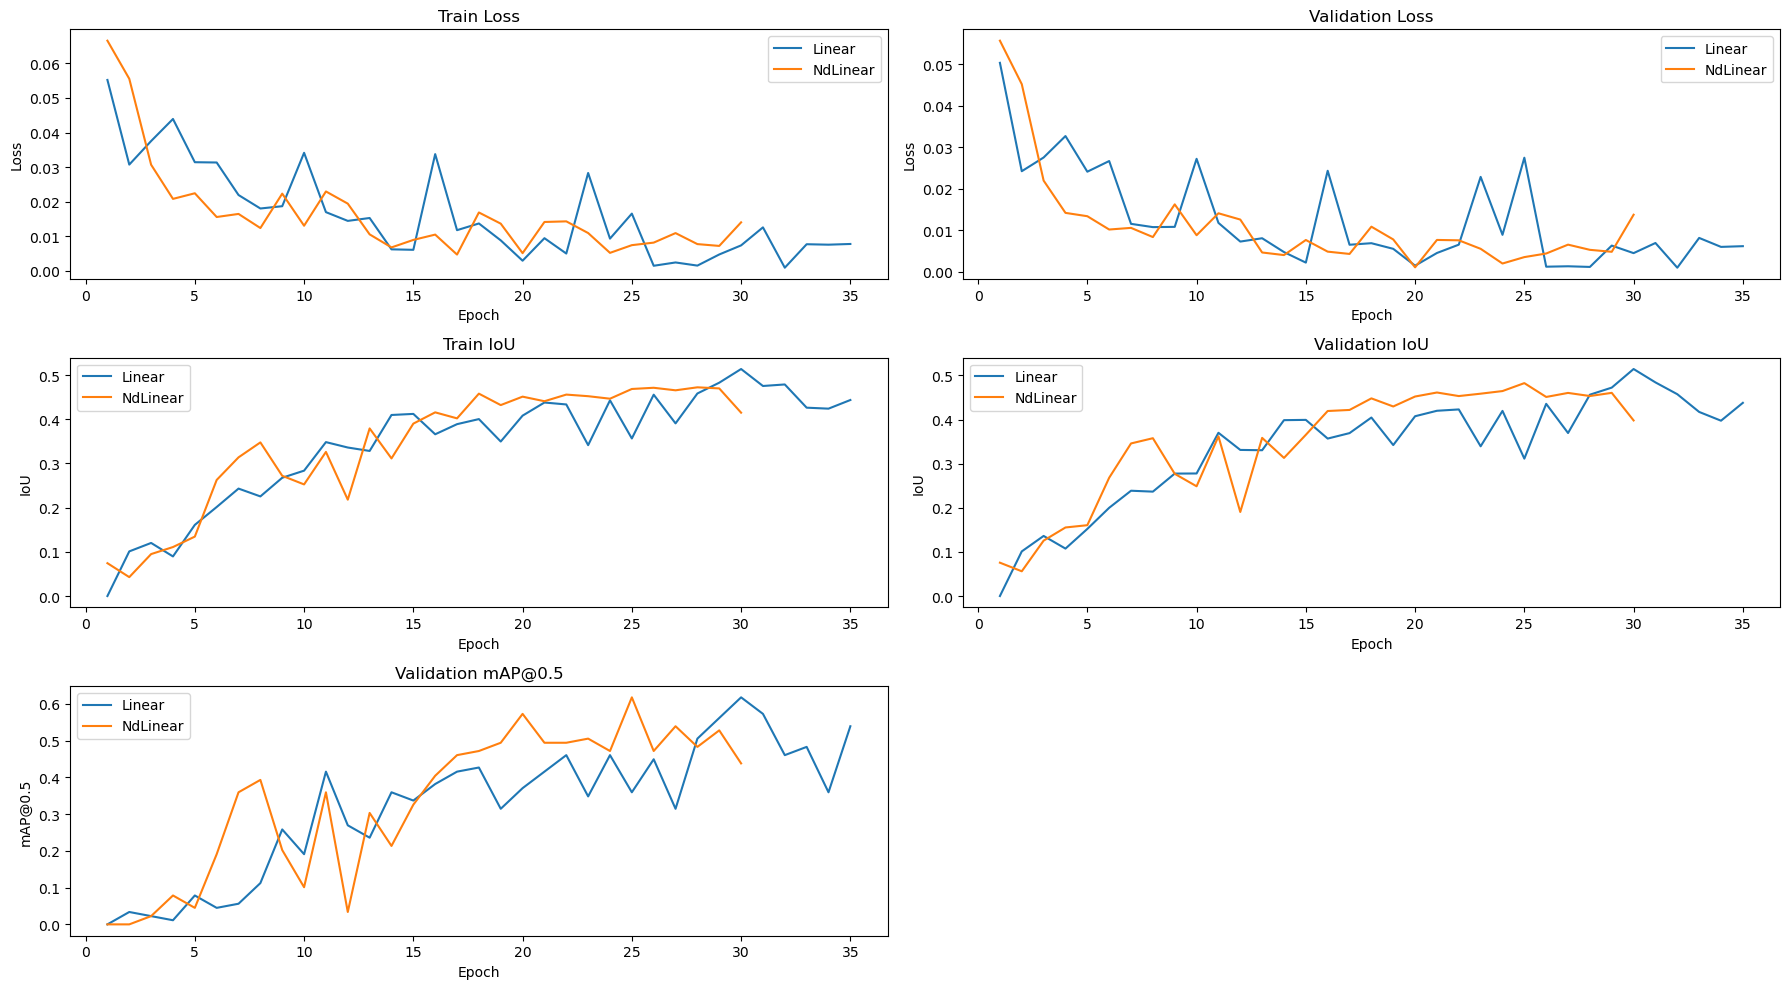

In [22]:
hist1 = pd.read_csv("training_metrics_bbox_log.csv")
hist2 = pd.read_csv("training_metrics_bbox_log_nd.csv")
plot_comparison(hist1, hist2, label1="Linear", label2="NdLinear")

**NdLinear-based model shows faster improvement in validation IoU**, reaching higher accuracy earlier in training compared to the standard linear head.  
**It also achieves comparable or better performance in validation mAP@0.5**, indicating more precise bounding box predictions.

# Character detection - Linear

In [114]:
import cv2
import numpy as np
from PIL import Image

# -------------------------
# Character Segmentation Function
# -------------------------
def segment_characters(image):
    """
    Segments individual characters from a license plate image.
    
    Args:
        image (np.ndarray): Input image (OpenCV format)
    
    Returns:
        chars (List[np.ndarray]): List of segmented character images (28x28)
    """
    # Resize image to a fixed height and width for consistency
    image = cv2.resize(image, (333, 75))

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding (inverse, using Otsu's method)
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations to clean small noise
    binary = cv2.erode(binary, np.ones((3, 3), np.uint8))
    binary = cv2.dilate(binary, np.ones((3, 3), np.uint8))

    # Set image borders to white to remove edge noise
    binary[0:3, :] = 255
    binary[:, 0:3] = 255
    binary[72:75, :] = 255
    binary[:, 330:333] = 255

    # Find contours from inverted binary image
    contours, _ = cv2.findContours(~binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    chars = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Filter out noise based on character size
        if 15 < h < 70 and 5 < w < 60:
            char_img = binary[y:y+h, x:x+w]
            char_img = cv2.resize(char_img, (28, 28))  # Resize to 28x28 for classifier
            chars.append(char_img)

    # Sort characters from left to right based on x-coordinate
    chars = sorted(chars, key=lambda img: cv2.boundingRect(img)[0])

    return chars

In [115]:
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Define global character mapping (0–9, A–Z)
ALL_CHARS = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"

class CharacterDataset(Dataset):
    """
    Custom Dataset for character-level license plate recognition.
    Extracts characters from bounding boxes and pairs them with labels.
    """
    def __init__(self, df, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing file paths, bounding boxes, and license plate strings
            transform (callable, optional): Transformations applied to each character image
        """
        self.transform = transform or transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((28, 28)),
            transforms.ToTensor()
        ])
        self.samples = self.extract_characters(df)

    def extract_characters(self, df):
        """
        Extracts individual character images and labels from the license plate bounding box.

        Returns:
            samples (List[Tuple[PIL.Image, int]]): List of (character image, label) pairs
        """
        samples = []

        for _, row in df.iterrows():
            try:
                # Load full image and extract license plate region
                image = Image.open(row["file_path"]).convert("RGB")
                bbox = eval(row["bbox"]) if isinstance(row["bbox"], str) else row["bbox"]
                plate = str(row["license_plate.number"]).upper()

                # Crop the bounding box region
                x_min, y_min, x_max, y_max = map(int, bbox)
                cropped = np.array(image)[y_min:y_max, x_min:x_max]

                # Segment characters from the cropped plate region
                char_imgs = segment_characters(cropped)

                # Skip plates with incorrect number of segments
                if len(char_imgs) != len(plate):
                    continue

                # Map characters to numeric labels (0-9, A-Z => 0-35)
                for img, char in zip(char_imgs, plate):
                    if char.isdigit():
                        label = int(char)
                    elif char.isalpha():
                        label = ord(char.upper()) - ord('A') + 10
                    else:
                        continue  # Skip unknown symbols

                    samples.append((Image.fromarray(img), label))

            except Exception as e:
                # Skip rows with errors (e.g., file not found, bad bbox)
                continue

        return samples

    def __len__(self):
        """Returns total number of character samples."""
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Retrieves the transformed character image and its corresponding label.

        Returns:
            image (Tensor): Transformed character image
            label (Tensor): Integer label of the character
        """
        image, label = self.samples[idx]
        return self.transform(image), torch.tensor(label)

In [116]:
import torch.nn as nn
import torch.nn.functional as F

class CharCNNLinear(nn.Module):
    """
    Convolutional Neural Network for character classification.
    Designed for grayscale (1-channel) 28x28 character images.
    """
    def __init__(self, num_classes=36):
        """
        Args:
            num_classes (int): Number of character classes (default: 36 for 0–9 + A–Z)
        """
        super().__init__()

        self.net = nn.Sequential(
            # --- Convolutional Layers ---
            nn.Conv2d(1, 32, 3, padding=1),     # Input: 1x28x28 -> Output: 32x28x28
            nn.ReLU(),
            nn.MaxPool2d(2),                    # Output: 32x14x14

            nn.Conv2d(32, 64, 3, padding=1),    # Output: 64x14x14
            nn.ReLU(),
            nn.MaxPool2d(2),                    # Output: 64x7x7

            nn.Conv2d(64, 128, 3, padding=1),   # Output: 128x7x7
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=1),  # Output: 128x7x7
            nn.ReLU(),
            nn.MaxPool2d(2),                    # Output: 128x3x3

            # --- Fully Connected Layers ---
            nn.Flatten(),                       # Flatten to vector of size 128*3*3 = 1152
            nn.Linear(128 * 3 * 3, 256),        # Dense layer
            nn.ReLU(),
            nn.Linear(256, num_classes)         # Output layer for classification
        )

    def forward(self, x):
        """
        Forward pass through the CNN.
        Args:
            x (Tensor): Input tensor of shape [B, 1, 28, 28]
        Returns:
            Tensor: Output logits of shape [B, num_classes]
        """
        return self.net(x)

# Character detection - NDLinear

In [117]:
from ndlinear import NdLinear  # Ensure ndlinear is available in your environment
import torch.nn as nn

class CharCNNNdLinear(nn.Module):
    """
    CNN-based character classification model using NdLinear for multidimensional feature interactions.
    Designed for grayscale 28x28 character inputs (e.g., from license plates).
    """
    def __init__(self, num_classes=36):
        """
        Args:
            num_classes (int): Number of output classes (default = 36 for 0-9 and A-Z)
        """
        super().__init__()

        # --- Convolutional feature extractor ---
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),     # (1, 28, 28) → (32, 14, 14)
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),    # (64, 14, 14) → (64, 7, 7)
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),                    # (128, 7, 7)
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # (128, 7, 7) → (128, 3, 3)
        )

        # --- NdLinear Head ---
        # Reshaped input is (B, 128, 9), so NdLinear operates over 9 spatial tokens per channel
        self.nd = NdLinear(input_dims=(128, 9), hidden_size=(256, 9))  # Projects (B, 128, 9) → (B, 256, 9)
        self.fc = nn.Linear(256 * 9, num_classes)                      # Final classifier layer

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (Tensor): Input tensor of shape (B, 1, 28, 28)

        Returns:
            Tensor: Output logits of shape (B, num_classes)
        """
        x = self.cnn(x)                           # (B, 128, 3, 3)
        x = x.view(x.size(0), 128, -1)            # Reshape to (B, 128, 9) for NdLinear
        x = self.nd(x)                            # (B, 256, 9)
        x = x.view(x.size(0), -1)                 # Flatten to (B, 256 * 9)
        return self.fc(x)                         # Final classification logits


In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# Select device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def train_model(model, dataloader, epochs=5):
    """
    Trains a character classification model using cross-entropy loss and Adam optimizer.

    Args:
        model (nn.Module): The model to train
        dataloader (DataLoader): DataLoader providing (image, label) pairs
        epochs (int): Number of training epochs (default = 5)

    Returns:
        history (dict): Dictionary with keys "loss", "acc", and "time" tracking metrics per epoch
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # Initialize log history for tracking performance
    history = {"loss": [], "acc": [], "time": []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        # Loop through all batches
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass and loss computation
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagation and optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        end_time = time.time()

        # Compute epoch metrics
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = correct / total
        epoch_time = end_time - start_time

        # Save metrics to history
        history["loss"].append(epoch_loss)
        history["acc"].append(epoch_acc)
        history["time"].append(epoch_time)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | Time: {epoch_time:.2f}s")

    return history

Using device: cuda


In [119]:
batch_size = 64
epochs = 100

# Prepare dataset and dataloader
char_dataset = CharacterDataset(df_all)
char_loader = DataLoader(char_dataset, batch_size=batch_size, shuffle=True)

# --- Train CharCNNLinear ---
print("\nTraining CharCNNLinear:")
model_linear = CharCNNLinear()
history_linear = train_model(model_linear, char_loader, epochs)

# --- Train CharCNNNdLinear ---
print("\nTraining CharCNNNdLinear:")
model_nd = CharCNNNdLinear()
history_nd = train_model(model_nd, char_loader, epochs)


Training CharCNNLinear:
Epoch 1/100 - Loss: 3.4577 | Acc: 0.0610 | Time: 0.12s
Epoch 2/100 - Loss: 3.4014 | Acc: 0.0572 | Time: 0.11s
Epoch 3/100 - Loss: 3.3840 | Acc: 0.0677 | Time: 0.11s
Epoch 4/100 - Loss: 3.3646 | Acc: 0.0724 | Time: 0.11s
Epoch 5/100 - Loss: 3.3636 | Acc: 0.0801 | Time: 0.11s
Epoch 6/100 - Loss: 3.3691 | Acc: 0.0744 | Time: 0.11s
Epoch 7/100 - Loss: 3.3432 | Acc: 0.0953 | Time: 0.11s
Epoch 8/100 - Loss: 3.2971 | Acc: 0.1258 | Time: 0.11s
Epoch 9/100 - Loss: 3.2423 | Acc: 0.1182 | Time: 0.11s
Epoch 10/100 - Loss: 3.1357 | Acc: 0.1659 | Time: 0.11s
Epoch 11/100 - Loss: 3.0371 | Acc: 0.1802 | Time: 0.11s
Epoch 12/100 - Loss: 2.9614 | Acc: 0.2021 | Time: 0.11s
Epoch 13/100 - Loss: 2.8580 | Acc: 0.2307 | Time: 0.11s
Epoch 14/100 - Loss: 2.7348 | Acc: 0.2450 | Time: 0.11s
Epoch 15/100 - Loss: 2.5985 | Acc: 0.2622 | Time: 0.11s
Epoch 16/100 - Loss: 2.4401 | Acc: 0.2822 | Time: 0.11s
Epoch 17/100 - Loss: 2.2798 | Acc: 0.3432 | Time: 0.11s
Epoch 18/100 - Loss: 2.1073 | Ac

In [120]:
import json
import os


# Save CharCNNLinear training history
with open("charcnn_linear_history.json", "w") as f:
    json.dump(history_linear, f, indent=4)

# Save CharCNNNdLinear training history
with open("charcnn_ndlinear_history.json", "w") as f:
    json.dump(history_nd, f, indent=4)

print("Training logs saved")


Training logs saved


In [121]:
torch.save(model_linear.state_dict(), "char_cnn_linear.pth")
torch.save(model_nd.state_dict(), "char_cnn_ndlinear.pth")

# Model Comparision

In [122]:
def plot_comparison(hist1, hist2, label1="Linear", label2="NdLinear"):
    """
    Plots and compares training metrics (loss, accuracy, and epoch time) between two models.

    Args:
        hist1 (dict): Training history of the first model (must include "loss", "acc", "time")
        hist2 (dict): Training history of the second model
        label1 (str): Label for the first model (e.g., "Linear")
        label2 (str): Label for the second model (e.g., "NdLinear")
    """
    epochs = range(1, len(hist1["loss"]) + 1)
    plt.figure(figsize=(15, 4))

    # --- Plot Loss ---
    plt.subplot(1, 3, 1)
    plt.plot(epochs, hist1["loss"], label=label1)
    plt.plot(epochs, hist2["loss"], label=label2)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # --- Plot Accuracy ---
    plt.subplot(1, 3, 2)
    plt.plot(epochs, hist1["acc"], label=label1)
    plt.plot(epochs, hist2["acc"], label=label2)
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # --- Plot Time per Epoch ---
    plt.subplot(1, 3, 3)
    plt.plot(epochs, hist1["time"], label=label1)
    plt.plot(epochs, hist2["time"], label=label2)
    plt.title("Epoch Time")
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.legend()

    plt.tight_layout()
    plt.show()

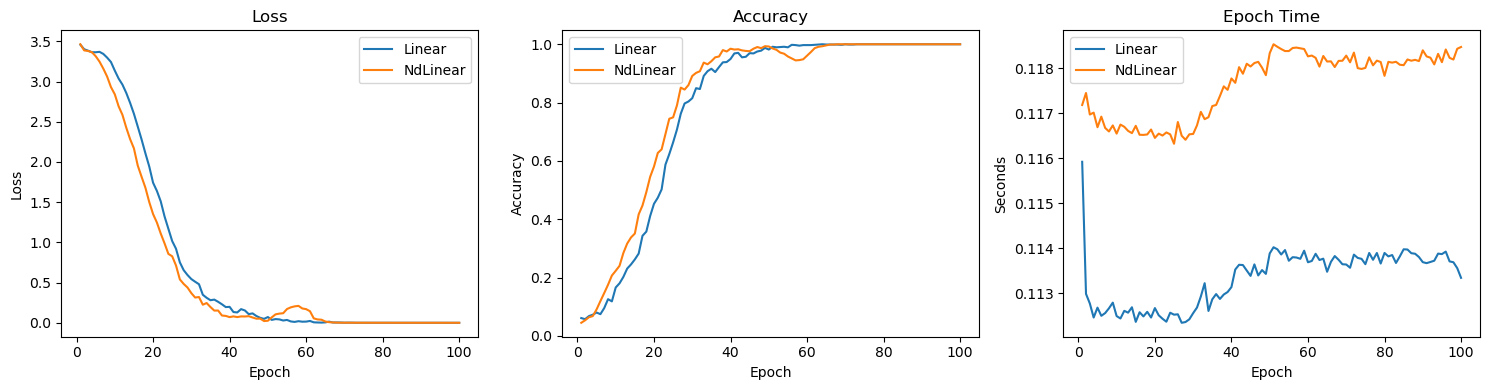

In [123]:
plot_comparison(history_linear, history_nd)

# Pipeline

In [136]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

def decode_pred_class(pred_class):
    """
    Maps a predicted class index to its corresponding alphanumeric character.

    Args:
        pred_class (int): Predicted class index

    Returns:
        str: Decoded character or "?" if invalid index
    """
    return ALL_CHARS[pred_class] if 0 <= pred_class < len(ALL_CHARS) else "?"

def run_prediction_pipeline(image_paths, bbox_model_path, char_model_path, image_size=(384, 384), device=None):
    """
    Runs full license plate recognition pipeline:
    - Predicts bounding box
    - Crops and segments characters
    - Classifies characters with a CNN

    Args:
        image_paths (List[str]): List of image file paths
        bbox_model_path (str): Path to trained bounding box model
        char_model_path (str): Path to trained character classifier
        image_size (tuple): Resize dimension for bounding box prediction model
        device (torch.device): CPU or GPU for inference

    Returns:
        List[dict]: Predictions including image path, predicted bbox, and plate text
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load bounding box model
    bbox_model = ResNet101NdBBoxRegressor()
    bbox_model.load_state_dict(torch.load(bbox_model_path, map_location=device))
    bbox_model.to(device).eval()

    # Load character recognition model
    char_model = CharCNNNdLinear()
    char_model.load_state_dict(torch.load(char_model_path, map_location=device))
    char_model.to(device).eval()

    # Transform for bounding box model input
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])

    results = []

    for img_path in image_paths:
        # --- Load and preprocess full image ---
        image = Image.open(img_path).convert("RGB")
        original_w, original_h = image.size

        resized_tensor = transform(image).unsqueeze(0).to(device)

        # --- Predict normalized bounding box coordinates ---
        with torch.no_grad():
            pred_bbox = bbox_model(resized_tensor).squeeze().cpu().numpy()

        # --- Rescale bbox to original image resolution ---
        x1, y1, x2, y2 = pred_bbox
        x1 = int(x1 * original_w)
        y1 = int(y1 * original_h)
        x2 = int(x2 * original_w)
        y2 = int(y2 * original_h)

        # --- Add padding around the bounding box ---
        pad_x = int(0.10 * (x2 - x1))
        pad_y = int(0.20 * (y2 - y1))
        x1_exp = max(x1 - pad_x, 0)
        y1_exp = max(y1 - pad_y, 0)
        x2_exp = min(x2 + pad_x, original_w)
        y2_exp = min(y2 + pad_y, original_h)

        # --- Crop and convert for OpenCV processing ---
        cropped_plate = image.crop((x1_exp, y1_exp, x2_exp, y2_exp))
        cropped_plate_cv = cv2.cvtColor(np.array(cropped_plate), cv2.COLOR_RGB2BGR)

        # --- Segment individual characters from plate image ---
        char_images = segment_characters(cropped_plate_cv)

        # --- Classify each character ---
        predicted_str = ""
        char_preds = []

        for char_img in reversed(char_images):  # Reverse to correct reading order if needed
            norm_char = char_img / 255.0
            char_tensor = torch.tensor(norm_char, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

            with torch.no_grad():
                logits = char_model(char_tensor)
                pred_class = logits.argmax(dim=-1).item()

            pred_char = decode_pred_class(pred_class)
            predicted_str += pred_char
            char_preds.append((char_img, pred_char))

        # --- Visualize segmented characters ---
        if len(char_preds) > 0:
            fig, axes = plt.subplots(1, len(char_preds), figsize=(2 * len(char_preds), 2))
            if len(char_preds) == 1:
                axes = [axes]
            for i, (img, char) in enumerate(char_preds):
                axes[i].imshow(img, cmap='gray')
                axes[i].axis('off')
            plt.suptitle(f"Predicted Plate: {predicted_str}", fontsize=16)
            plt.tight_layout()
            plt.show()

        # --- Store results ---
        results.append({
            'image_path': img_path,
            'predicted_bbox': [x1_

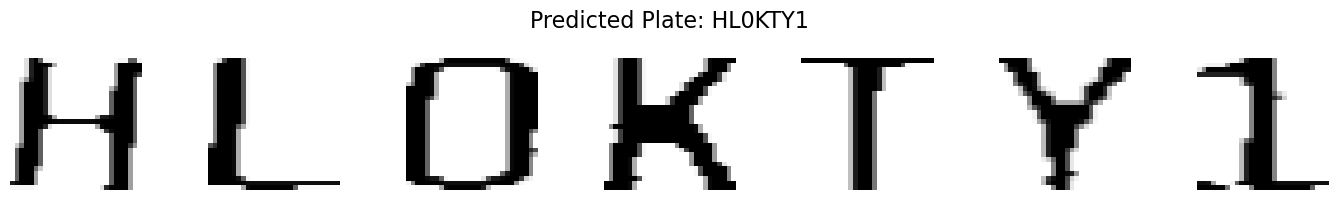

Image: data/us/us6.jpg
BBox: [359, 542, 639, 665]
Plate: HL0KTY1


In [137]:
# Example usage
test_image_paths = [
    "data/us/us6.jpg",
    
]

bbox_model_path = "best_resnet101_nd_ciou.pth"
char_model_path = "char_cnn_ndlinear.pth"

results = run_prediction_pipeline(
    image_paths=test_image_paths,
    bbox_model_path=bbox_model_path,
    char_model_path=char_model_path
)

for result in results:
    print("Image:", result["image_path"])
    print("BBox:", result["predicted_bbox"])
    print("Plate:", result["predicted_plate"])

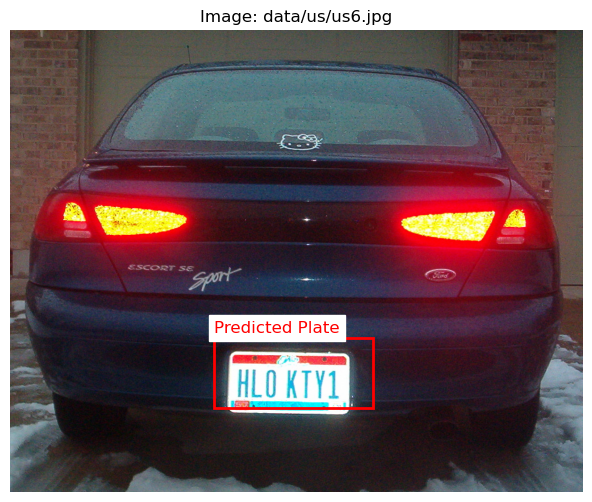

In [138]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_bbox_on_image(image_path, bbox, label=None, color='red'):
    """
    Plots a bounding box on an image with an optional label.

    Args:
        image_path (str): Path to the image file
        bbox (list or tuple): Bounding box in [x1, y1, x2, y2] format
        label (str, optional): Label text to display above the box
        color (str): Color of the bounding box and label (default: 'red')
    """
    # Load image and unpack bbox coordinates
    image = Image.open(image_path).convert("RGB")
    x1, y1, x2, y2 = bbox

    # Create matplotlib figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.imshow(image)

    # Draw bounding box
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor=color, facecolor='none'
    )
    ax.add_patch(rect)

    # Add optional label
    if label:
        ax.text(
            x1, y1 - 10, label,
            color=color, fontsize=12,
            backgroundcolor='white'
        )

    # Final formatting
    ax.set_title(f"Image: {image_path}")
    ax.axis("off")
    plt.show()

# Example usage
plot_bbox_on_image("data/us/us6.jpg", result["predicted_bbox"], label="Predicted Plate")